<a href="https://colab.research.google.com/github/mihirkumar28/LP-3/blob/main/Decision_Tree_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Generating dataset
data = {
    'age': ['<21', '<21', '21-35', '>35', '>35', '>35', '21-35', '<21', '<21', '>35', '<21', '21-35', '21-35', '>35'], 
    'income':['high','high','high','medium','low','low','low','medium','low','medium','medium','medium','high','medium'],
    'gender':['male','male','male','male','female','female','female','male','female','female','female','male','female','male'],
    'marital_status':['single', 'married', 'single', 'single', 'single', 'married', 'married', 'single', 'married','single','married','married','single','married'],
    'buys':['no','no','yes','yes','yes','no','yes','no','yes','yes','yes','yes','yes','no']
} 
df = pd.DataFrame.from_dict(data) 
df.head()

,age,income,gender,marital_status,buys
0,<21,high,male,single,no
1,<21,high,male,married,no
2,21-35,high,male,single,yes
3,>35,medium,male,single,yes
4,>35,low,female,single,yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             14 non-null     object
 1   income          14 non-null     object
 2   gender          14 non-null     object
 3   marital_status  14 non-null     object
 4   buys            14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

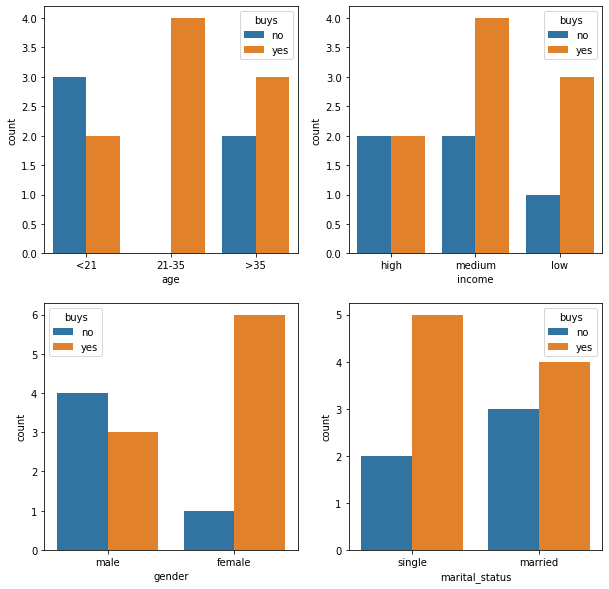

In [ ]:
_,axes=plt.subplots(2,2,figsize=(10,10))
sns.countplot(df.age,hue=df['buys'],ax=axes[0,0])
sns.countplot(df.income,hue=df['buys'],ax=axes[0,1])
sns.countplot(df.gender,hue=df['buys'],ax=axes[1,0])
sns.countplot(df.marital_status,hue=df['buys'],ax=axes[1,1])
plt.show()

In [ ]:
def encode_data(df, target):
    cat_cols = []
    for column in df.columns:
        if (df[column].dtype == "object") and (column != target): 
            if len(df[column].unique()) > 2: 
                cat_cols.append(column)
                features = df[column].value_counts().index.tolist()
                for key in features:
                    col_name = f"{column}_{key}"
                    df[col_name] = 0
                    df.loc[df[column] == key, col_name] = 1
    df.drop(columns=cat_cols,inplace=True)
    return df

In [ ]:
def preprocess_data(df):
    df_encoded = encode_data(df, 'buys') 
    for col in df.columns:
        if (df[col].dtype == "object") and (len(df[col].unique()) == 2):
            unique_values = df[col].unique()
            df_encoded[col]=df_encoded[col].map({f'{unique_values[0]}':0, f'{unique_values[1]}':1})
    return df_encoded

In [ ]:
df_encoded = preprocess_data(df.copy())
print(df_encoded)

    gender  marital_status  buys  ...  income_medium  income_high  income_low
0        0               0     0  ...              0            1           0
1        0               1     0  ...              0            1           0
2        0               0     1  ...              0            1           0
3        0               0     1  ...              1            0           0
4        1               0     1  ...              0            0           1
5        1               1     0  ...              0            0           1
6        1               1     1  ...              0            0           1
7        0               0     0  ...              1            0           0
8        1               1     1  ...              0            0           1
9        1               0     1  ...              1            0           0
10       1               1     1  ...              1            0           0
11       0               1     1  ...              1            

In [ ]:
def gini_index(feature, data):
    gini_index = 0
    if len(data) == 0:
        return 0
    else: total_count = len(data)   
    unique_target_values = data['buys'].unique()
    unique_feature_values = data[feature].unique()
    for j in unique_target_values: 
        target_value_count = data['buys'].value_counts()[j]
        probability2_sum = 0
        for i in unique_feature_values:
            count = len(data[(data[feature] == i) & (data['buys'] == j)])
            probability = count/target_value_count
            probability2_sum = probability2_sum + probability**2
        target_probability = target_value_count/total_count
        gini_index = gini_index + (1 - probability2_sum)*(target_probability)
    return gini_index

In [ ]:
def find_best_split(features, data, metric):
    print('Available features =', len(features))
    print('Number of datapoints =', len(data))
    best_feature = ''
    best_metric = 1
    for feature in features:
        if metric=='gini':
            curr_criteria = gini_index(feature, data)
        if curr_criteria < best_metric:
            best_feature=feature
            best_metric=curr_criteria
            
    print(f'Best feature: {best_feature} with {metric} = {best_metric}')
    return best_feature

In [ ]:
def create_leaf(data):
    leaf = {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'is_leaf': True,
            'size': len(data)}
    target_value_counts = data['buys'].value_counts()
    target_unique_values = data['buys'].unique()
    predicted_value = target_unique_values[0]
    for i in target_unique_values:
        if target_value_counts[i] > target_value_counts[predicted_value]:
            predicted_value = i
    leaf['prediction'] = predicted_value
    return leaf 

In [ ]:
def check_purity(data):
    target_value_counts = data['buys'].value_counts()
    target_unique_values = data['buys'].unique()
    for i in target_unique_values:
        if target_value_counts[i] == 0:
            return True
    return False

In [ ]:
def create_decision_tree(rem_features, data, curr_depth, metric, max_depth):
    if rem_features == []:
        return create_leaf(data)
    
    if check_purity(data):
        return create_leaf(data)
    
    if curr_depth>=max_depth:
        return create_leaf(data)
    
    if len(data)<3:
        return create_leaf(data)
    
    print('\nFor level', curr_depth)
    selected_feature = find_best_split(rem_features, data, metric)
    
    rem_features.remove(selected_feature)
    left_split=data[data[selected_feature]==0]
    right_split=data[data[selected_feature]==1]
    
    if len(left_split) == len(data):
        return create_leaf(left_split)
    
    if len(right_split) == len(data):
        return create_leaf(right_split)
    
    left=create_decision_tree(rem_features, left_split, curr_depth+1, metric, max_depth)
    right=create_decision_tree(rem_features, right_split, curr_depth+1, metric, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': selected_feature,
            'left'             : left, 
            'right'            : right,
            'size'             : len(data)}

In [ ]:
def print_tree(tree, level, store):
    if not tree:
        return
    split_name = tree['splitting_feature']
    dashes='-'*level*3
    
    string=''
    if tree['is_leaf']==False:
        print(dashes, store)
    else:
        if tree['size']>0:
            print(dashes, store, " PREDICTION: ", tree['prediction'], 'size=', tree['size'])
    
    left_store=store.copy()
    left_store[split_name]=0
    print_tree(tree['left'], level+1, left_store)
    
    right_store=store.copy()
    right_store[split_name]=1
    print_tree(tree['right'], level+1, right_store)

In [ ]:
def build_tree(df_encoded, max_depth, metric):
    features = list(df_encoded.columns)
    features.remove('buys')
    decision_tree=create_decision_tree(features, df_encoded, 0, metric, max_depth)
    return decision_tree

In [ ]:
metric =  'gini'
max_depth = 1
decision_tree = build_tree(df_encoded, max_depth, metric)


For level 0
Available features = 8
Number of datapoints = 14
Best feature: age_21-35 with gini = 0.31746031746031744
